Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing all the important libraries

In [3]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import Dense

In [4]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [5]:
# prompt: logic to read zip file uploaded in google drive path https://drive.google.com/file/d/1xLfSQUGDl8ezNNbUkpuHOYvSpTyxVhCs/view?usp=sharing

import zipfile
from google.colab import drive

# Specify the path to your zip file in Google Drive
zip_file_path = '/content/gdrive/My Drive/CNN_assignment.zip' # Replace 'your_zip_file.zip' with the actual file name

# Create a ZipFile object
try:
  with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract all contents to a specific directory
    extraction_path = '/content/gdrive/My Drive/extracted_data2'
    zip_ref.extractall(extraction_path)
    print(f"Successfully extracted contents of {zip_file_path} to {extraction_path}")
except FileNotFoundError:
  print(f"Error: File not found at {zip_file_path}")
except zipfile.BadZipFile:
  print(f"Error: Invalid zip file at {zip_file_path}")
except Exception as e:
  print(f"An unexpected error occurred: {e}")

Successfully extracted contents of /content/gdrive/My Drive/CNN_assignment.zip to /content/gdrive/My Drive/extracted_data2


In [6]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("Num CPUs Available: ", len(tf.config.list_physical_devices('CPU')))


Num GPUs Available:  1
Num CPUs Available:  1


In [7]:
# Defining the path for train and test images
import pathlib

train_dataset_path = pathlib.Path(r"/content/gdrive/My Drive/extracted_data2/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
test_dataset_path = pathlib.Path('/content/gdrive/My Drive/extracted_data2/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

data_dir_train = pathlib.Path(train_dataset_path)
data_dir_test = pathlib.Path(test_dataset_path)

In [8]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Create a dataset

Define some parameters for the loader:

In [9]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [10]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [11]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [12]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

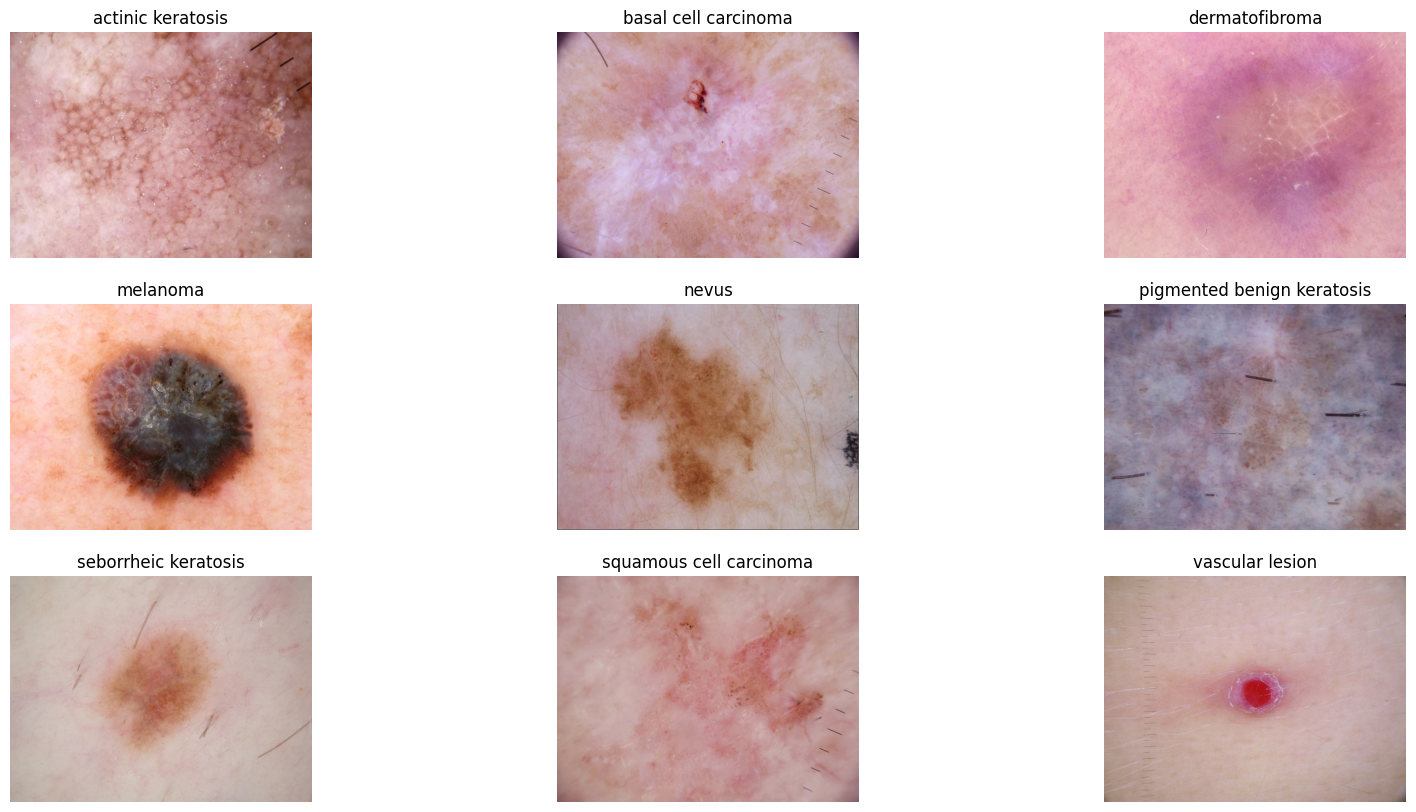

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize = (20,10))
for i in range(len(class_names)):
  plt.subplot(3, 3, i+1)
  image = plt.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[2]))
  plt.imshow(image)
  plt.title(class_names[i])
  plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [14]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [15]:
input_shape = (180,180,3)
pool_size = (2,2)

model = Sequential()
model.add(layers.Rescaling(1./255, input_shape=input_shape))
model.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
model.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D(pool_size = pool_size))

model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2, 2)))

model.add(layers.Conv2D(128, 3, padding='same', activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(9, activation='softmax'))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Compile the model
Choose an appropirate optimiser and loss function for model training

In [16]:
def compile_model(model):
    model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

compile_model(model)

In [17]:
# View the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 180, 180, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 45, 45, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 61952)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       7,929,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,033,641 (30.65 MB)

 Trainable params: 8,033,641 (30.65 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [18]:
def train_model(train_ds, val_ds, epochs):
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs
    )
    return history

epocs = 20
history = train_model(train_ds, val_ds, epocs)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:609: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


56/56 ━━━━━━━━━━━━━━━━━━━━ 40s 245ms/step - accuracy: 0.1989 - loss: 2.3371 - val_accuracy: 0.2774 - val_loss: 1.9480
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.3121 - loss: 1.8590 - val_accuracy: 0.4340 - val_loss: 1.6653
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accuracy: 0.4106 - loss: 1.6623 - val_accuracy: 0.4519 - val_loss: 1.5624
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accuracy: 0.4336 - loss: 1.5041 - val_accuracy: 0.4877 - val_loss: 1.4949
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.5239 - loss: 1.3492 - val_accuracy: 0.4832 - val_loss: 1.4828
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.5222 - loss: 1.3500 - val_accuracy: 0.5369 - val_loss: 1.3906
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.5967 - loss: 1.1830 - val_accuracy: 0.5414 - val_loss: 1.4128
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accuracy: 0.5944 - loss: 1.1135 - val_accuracy: 0.5391 - val_loss: 

### Visualizing training results

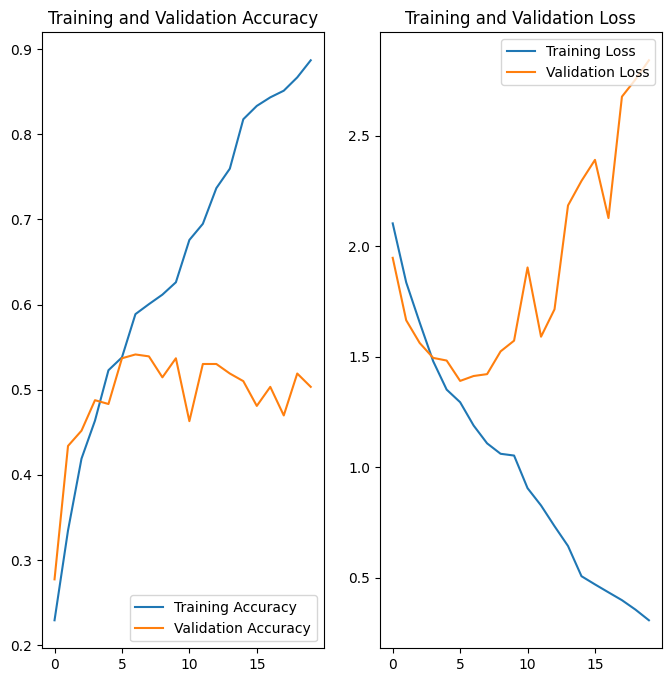

In [19]:
def visualize_results(history, epochs_size):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs_size)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()


visualize_results(history, epocs)


#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

* The models accuracy on the training data set is 90%, but its accuracy on the validation data set is only 50%.
* This indicates that the model is overfitting, as it performs well on the training data but poorly on the validation data.
* Additionally, the validation loss is much higher than the training loss, further supporting the conclusion that the model is overfitting.

In [21]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

data_augmentation = tf.keras.Sequential(
    [
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.2),
    ]
)

# plot one of the augumented image to see the different versions of it.
image, label = next(iter(train_ds))

image = np.array(image,np.int32)
plt.figure(figsize=(10,10))

for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  augumented_image1 = np.array(augmented_image[0],np.int32)
  plt.imshow(augumented_image1)
  plt.axis('off')

### Create the model, compile and train the model (with Dropout Layer)


In [22]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

model = Sequential()
model.add(layers.Rescaling(1./255, input_shape=input_shape))
model.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
model.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D(pool_size = pool_size))

model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2, 2)))

model.add(layers.Conv2D(128, 3, padding='same', activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(9, activation='softmax'))

### Compiling the model

In [23]:
compile_model(model)

### Training the model

In [24]:
history = train_model(train_ds, val_ds, 20)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step - accuracy: 0.1821 - loss: 2.6110 - val_accuracy: 0.2215 - val_loss: 2.0046
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - accuracy: 0.2537 - loss: 1.9884 - val_accuracy: 0.3602 - val_loss: 1.7733
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.3586 - loss: 1.7436 - val_accuracy: 0.3982 - val_loss: 1.6966
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.4184 - loss: 1.6422 - val_accuracy: 0.4743 - val_loss: 1.5967
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - accuracy: 0.5100 - loss: 1.3945 - val_accuracy: 0.4855 - val_loss: 1.4624
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 0.5176 - loss: 1.3171 - val_accuracy: 0.4944 - val_loss: 1.4725
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accuracy: 0.5592 - loss: 1.2581 - val_accuracy: 0.5145 - val_loss: 1.4700
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.5790 - loss: 1.2216 - val_accuracy: 0.5257 - v

### Visualizing the results

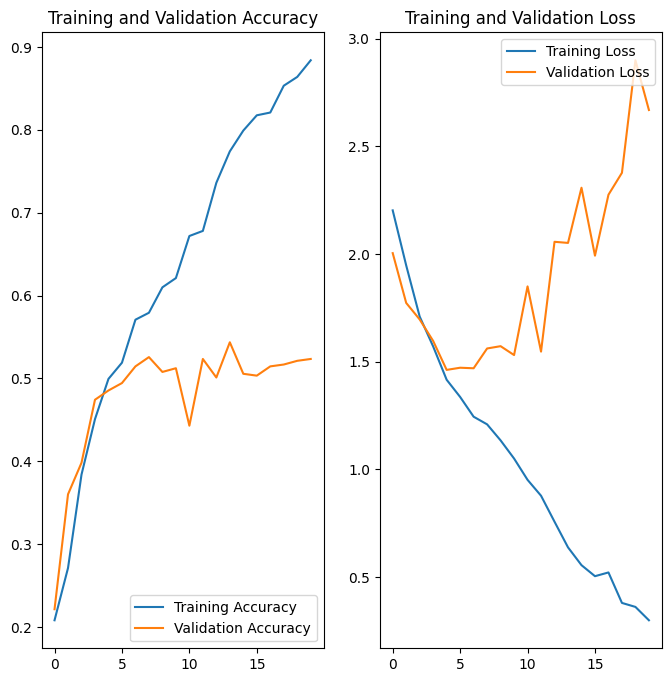

In [25]:
visualize_results(history, 20)

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

#### Findings:
* We don't notice a significant improvement in accuracy after adding the drop out layer

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

<function matplotlib.pyplot.show(close=None, block=None)>

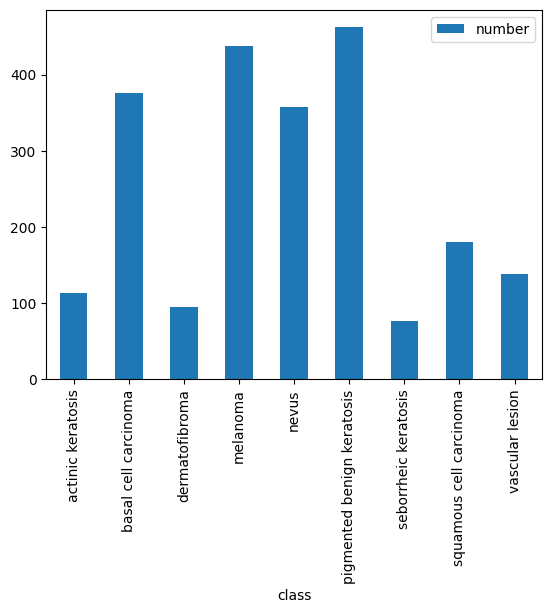

In [26]:
# images in each classes
image_class=pd.DataFrame()
for i in range(len(class_names)):
  name= class_names[i]
  number = len(list(data_dir_train.glob(f'{class_names[i]}/*.jpg')))
  image_class=image_class._append({'class':name,'number':number},ignore_index=True)

image_class
image_class.plot.bar(x='class',y='number',rot=90)
plt.show

#### **Todo:** Write your findings here:
#### - Which class has the least number of samples? **seborrheic keratosis**
#### - Which classes dominate the data in terms proportionate number of samples? **pigmented bengn keratosis**


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [27]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [28]:
path_to_training_dataset=train_dataset_path
import Augmentor
for i in class_names:

    p = Augmentor.Pipeline(path_to_training_dataset / i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/My Drive/extracted_data2/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7AF4E15A1060>: 100%|██████████| 500/500 [00:19<00:00, 25.99 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/My Drive/extracted_data2/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7AF4E1665270>: 100%|██████████| 500/500 [00:22<00:00, 22.32 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/My Drive/extracted_data2/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7AF4EC5D5F90>: 100%|██████████| 500/500 [00:20<00:00, 24.82 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/My Drive/extracted_data2/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7AF4E135F1C0>: 100%|██████████| 500/500 [01:19<00:00,  6.27 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/My Drive/extracted_data2/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7AF4E151D6C0>: 100%|██████████| 500/500 [01:15<00:00,  6.63 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/My Drive/extracted_data2/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7AF4E13564A0>: 100%|██████████| 500/500 [00:20<00:00, 24.26 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/My Drive/extracted_data2/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7AF4E13247F0>: 100%|██████████| 500/500 [00:38<00:00, 12.87 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/My Drive/extracted_data2/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7AF4E151D630>: 100%|██████████| 500/500 [00:21<00:00, 23.76 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/My Drive/extracted_data2/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7AF4E151F880>: 100%|██████████| 500/500 [00:19<00:00, 25.70 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [29]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [30]:
path_list=[]
label_list=[]
for i in class_names:
    for j in data_dir_train.glob(i+'/*.jpg'):
        path_list.append(str(j))
        label_list.append(i)
dataframe_dict_original = dict(zip(path_list, label_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df['Label'].value_counts()

Label
pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: count, dtype: int64

In [31]:
from glob import glob
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
# path_list

In [32]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
# lesion_list_new

In [33]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [34]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df._append(df2)

In [35]:
new_df['Label'].value_counts()

Label
pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [36]:
batch_size = 32
img_height = 180
img_width = 180

In [37]:
# prompt: code to resize hunders of images from a google drive to 180x180 size. Make sure to scan all the sub-directories to find such images.

import os
from PIL import Image

def resize_images(root_dir, new_size=(180, 180)):
    for subdir, _, files in os.walk(root_dir):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                filepath = os.path.join(subdir, file)
                try:
                    img = Image.open(filepath)
                    img = img.resize(new_size)
                    img.save(filepath)  # Overwrite the original image
                    print(f"Resized: {filepath}")
                except IOError as e:
                    print(f"Error processing {filepath}: {e}")

# Example usage (assuming your images are in /content/gdrive/My Drive/extracted_data):
resize_images(train_dataset_path)

Streaming output truncated to the last 5000 lines.
Resized: /content/gdrive/My Drive/extracted_data2/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0029578.jpg_1380b767-df65-47fb-bb35-b519b8df8214.jpg
Resized: /content/gdrive/My Drive/extracted_data2/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0033891.jpg_872414bf-006c-47a2-9a7b-fe6dc8ef1bba.jpg
Resized: /content/gdrive/My Drive/extracted_data2/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0030757.jpg_174e8c0b-5186-46fa-b028-d3ae398225ea.jpg
Resized: /content/gdrive/My Drive/extracted_data2/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0025223.jpg_400323fc-d11f-4ab3-9c33-cedda54b2079.jpg
Resized: /content/gdrive/My Drive/extracted_data2/Skin cancer

#### **Todo:** Create a training dataset

In [38]:
# data_dir_train="path to directory with training data + data created using augmentor"
data_dir_train=train_dataset_path
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [39]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


### Create model post augmentation (with normalization)

In [40]:
model = Sequential()
model.add(layers.Rescaling(1./255, input_shape=input_shape))
model.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
model.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size = pool_size))

model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D(pool_size=(2, 2)))

model.add(layers.Conv2D(128, 3, padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(9, activation='softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [41]:
compile_model(model)

In [42]:
epochs = 30
history = train_model(train_ds, val_ds, epochs)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:609: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


169/169 ━━━━━━━━━━━━━━━━━━━━ 39s 193ms/step - accuracy: 0.2008 - loss: 4.6997 - val_accuracy: 0.1359 - val_loss: 35.3108
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 27s 129ms/step - accuracy: 0.1919 - loss: 2.1152 - val_accuracy: 0.0928 - val_loss: 12.4576
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 25s 147ms/step - accuracy: 0.1879 - loss: 2.0996 - val_accuracy: 0.2725 - val_loss: 1.8965
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 41s 144ms/step - accuracy: 0.2616 - loss: 1.8929 - val_accuracy: 0.2294 - val_loss: 2.4912
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 40s 137ms/step - accuracy: 0.2735 - loss: 1.8243 - val_accuracy: 0.2294 - val_loss: 2.4364
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 40s 133ms/step - accuracy: 0.2835 - loss: 1.7637 - val_accuracy: 0.1255 - val_loss: 6.9340
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 23s 135ms/step - accuracy: 0.3393 - loss: 1.7090 - val_accuracy: 0.3081 - val_loss: 2.0076
Epoch 8/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 42s 142ms/step - accuracy: 0.3854 - loss: 1.5939 - v

In [43]:
visualize_results(history, epochs)

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

#### Findings

* Yes it did help. But looks like adding normalization have not given required accuracy. Validation accuracy is very wavy as we add the epocs.


### Create model post augmentation (without normalization)

In [44]:
# Model without Normalization
model = Sequential()
model.add(layers.Rescaling(1./255, input_shape=input_shape))
model.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
model.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D(pool_size = pool_size))

model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2, 2)))

model.add(layers.Conv2D(128, 3, padding='same', activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(9, activation='softmax'))

In [45]:
compile_model(model)

In [46]:
epochs = 30
history = train_model(train_ds, val_ds, epochs)

Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 26s 138ms/step - accuracy: 0.1831 - loss: 2.1391 - val_accuracy: 0.3318 - val_loss: 1.7268
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 38s 129ms/step - accuracy: 0.4000 - loss: 1.5567 - val_accuracy: 0.4269 - val_loss: 1.5634
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 42s 137ms/step - accuracy: 0.4495 - loss: 1.4172 - val_accuracy: 0.4952 - val_loss: 1.4119
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 39s 124ms/step - accuracy: 0.5065 - loss: 1.3082 - val_accuracy: 0.5509 - val_loss: 1.2693
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 42s 128ms/step - accuracy: 0.5538 - loss: 1.1858 - val_accuracy: 0.5828 - val_loss: 1.1483
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 41s 127ms/step - accuracy: 0.6199 - loss: 1.0323 - val_accuracy: 0.6318 - val_loss: 1.1244
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 41s 127ms/step - accuracy: 0.6667 - loss: 0.9255 - val_accuracy: 0.5479 - val_loss: 1.4121
Epoch 8/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 22s 129ms/step - accuracy: 0.6921 - loss: 0

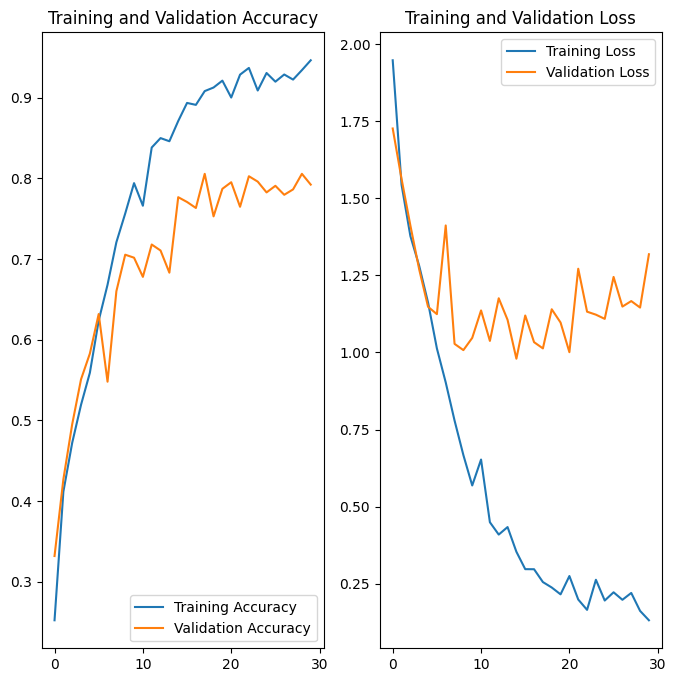

In [47]:
visualize_results(history, epochs)

### Findings:

From the above models we can say that rebalacing using Augmentor has improved the accuracy. We have good training accuracy of 94 and validation accuracy of close to 80.

### Model Prediction

In [74]:
def predict_melanoma_skin_cancer_class(image):
    img = np.expand_dims(image,axis=0)
    pred = model.predict(img)
    pred = np.argmax(pred)
    pred_class = class_names[pred]
    return pred_class


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


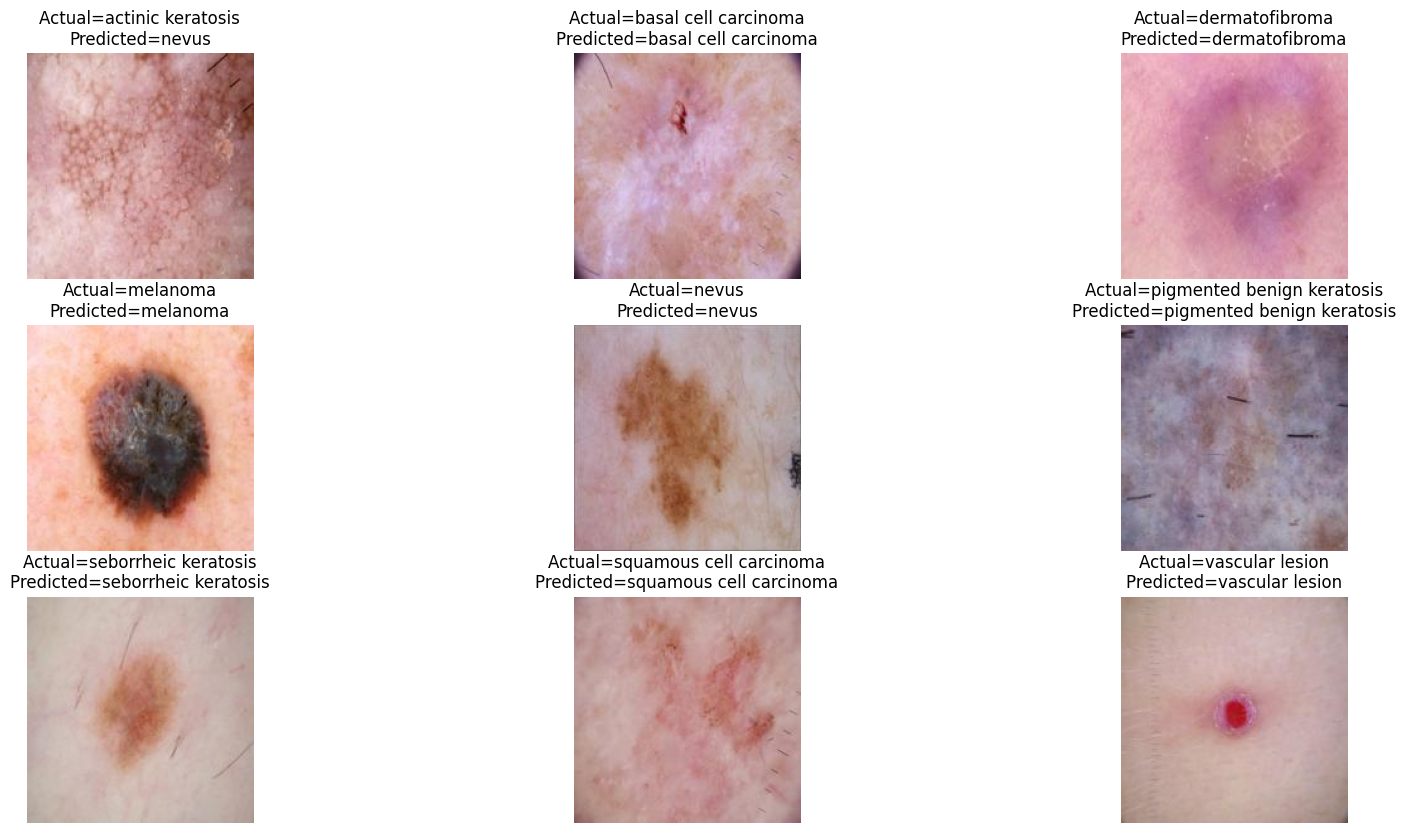

In [76]:
plt.figure(figsize = (20,10))
for i in range(len(class_names)):
  plt.subplot(3, 3, i+1)
  image = plt.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[2]))
  pred_class = predict_melanoma_skin_cancer_class(image)
  plt.imshow(image)
  plt.title("Actual="+ class_names[i] +'\n'+ "Predicted="+pred_class)
  plt.axis("off")
